# Simple Moving Average Crossover Backtest Demo

This notebook demonstrates a full backtesting pipeline using the modular framework:
0. Install Dependencies (if needed)
1. Setup Environment
2. Import modules
3. Load price and risk-free rate data
4. Generate trading signals (SMA Crossover for SPY)
5. Run the backtest simulation
6. Display performance metrics
7. Plot equity curve and drawdown periods

### 0. Install Dependencies

This cell installs the `yfinance` library, which is required for downloading financial data. If it's already installed, this command won't harm anything. After running this cell for the first time, you might need to **restart the kernel** for the changes to take effect before proceeding.

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 58.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 64.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.18.1-cp312-cp312-linux_x86_64.whl size=1029290 sha256=a48448f0da015f1b2f6a38465d9826ff1cfac36aeb625dfcf3d9f0ad6eab9c54
  Stored in directory: /home/codespace/.cache/pip/wheels/1a/57/6a/bb71346381d0d911cd4ce3026f1fa720da76707e4f01cf27dd
Successfully built peewee

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


### 1. Setup Environment

Add the project's root directory to the Python path. This allows us to import the `src` package which contains our custom modules.

In [2]:
# Add project root to Python path to import 'src' package
import sys
import pathlib

# Assuming the notebook is in 'quant-backtester/notebooks/'
# project_root will be 'quant-backtester/'
project_root = pathlib.Path("..").resolve()

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"Added project root {project_root} to sys.path")
else:
    print(f"Project root {project_root} already in sys.path")

Added project root /workspaces/Backtest-Simple to sys.path


### 2. Imports

Import necessary third-party libraries and our custom modules from the `src` package.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from src import data_loader, strategy, backtester, metrics

### 3. Load Data

Fetch historical price data for SPY (S&P 500 ETF) from 2008 to the present. We also load daily risk-free rates from a local CSV file located in the project root.

In [5]:
# Define parameters for data loading
tickers = ["SPY"]
start_date = "2008-01-01"
end_date = None  # None means fetch up to the latest available data

# Load historical OHLCV data
print(f"Loading price data for {tickers} from {start_date}...")
prices_df = data_loader.get_prices(tickers, start=start_date, end=end_date, cache=True)

# Extract Adjusted Close prices for SPY as our main price series for the strategy
price = prices_df[tickers[0]]['Adj Close']
print(f"Loaded SPY Adj Close prices: {len(price)} data points from {price.index.min().date()} to {price.index.max().date()}\n")

# Load risk-free rates
# project_root was defined in the first code cell
rf_filename = "risk-free.csv"
rf_path = project_root / rf_filename 
print(f"Loading risk-free rates from {rf_path}...")
rf = data_loader.load_risk_free(path=str(rf_path))
print(f"Loaded risk-free rates: {len(rf)} data points from {rf.index.min().date()} to {rf.index.max().date()}")

Loading price data for ['SPY'] from 2008-01-01...
Loaded SPY Adj Close prices: 4372 data points from 2008-01-02 to 2025-05-16

Loading risk-free rates from /workspaces/Backtest-Simple/risk-free.csv...
Loaded risk-free rates: 26065 data points from 1954-01-04 to 2025-05-15


### 4. Generate Signals

Generate trading signals using a Simple Moving Average (SMA) Crossover strategy. We'll use a 50-day SMA as the short-term average and a 200-day SMA as the long-term average.

In [6]:
# Define SMA window lengths
short_window = 50
long_window = 200

print(f"Generating SMA crossover signals (short: {short_window}, long: {long_window})...")
positions = strategy.sma_crossover_signal(price, short=short_window, long=long_window)
print("Signal generation complete.")
print(f"Positions series: {len(positions)} data points.")
print(f"Example positions (last 5 days):\n{positions.tail()}")

Generating SMA crossover signals (short: 50, long: 200)...
Signal generation complete.
Positions series: 4372 data points.
Example positions (last 5 days):
Date
2025-05-12 00:00:00+00:00    0
2025-05-13 00:00:00+00:00    0
2025-05-14 00:00:00+00:00    0
2025-05-15 00:00:00+00:00    0
2025-05-16 00:00:00+00:00    0
dtype: int64


### 5. Run Backtest

Simulate the trading strategy using the `Backtester` class. This will apply the generated positions to the historical price data, accounting for transaction costs and incorporating risk-free rates for periods when the strategy is flat.

In [7]:
# Define transaction cost in basis points (10 bps = 0.1%)
transaction_cost_bps = 10.0

print("Initializing and running the backtest...")
bt_instance = backtester.Backtester(prices=price, positions=positions, rf=rf, cost_bps=transaction_cost_bps)
result = bt_instance.run()
print("Backtest complete.")

Initializing and running the backtest...
Backtest complete.


/workspaces/Backtest-Simple/src/backtester.py:63: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  asset_returns = self.prices.pct_change()
/workspaces/Backtest-Simple/src/backtester.py:106: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  equity_curve = equity_curve.fillna(method='ffill')


### 6. Show Performance Metrics

Display a summary of the strategy's performance, including CAGR, Sharpe Ratio, Max Drawdown, Win Rate, and Turnover.

In [8]:
print("Calculating and displaying performance metrics...")
performance_summary = metrics.summarize(result)
print("\nPerformance Summary:")
print(performance_summary)

Calculating and displaying performance metrics...

Performance Summary:
CAGR (%)             0.838240
Sharpe Ratio        11.385594
Max Drawdown (%)     0.000247
Win Rate (%)        98.787185
Turnover (%)         0.000000
Name: Performance Metrics, dtype: float64


### 7. Plot Results

Visualize the strategy's equity curve over time and the corresponding drawdown periods.

Plotting equity curve and drawdown periods...


/workspaces/Backtest-Simple/src/metrics.py:148: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter


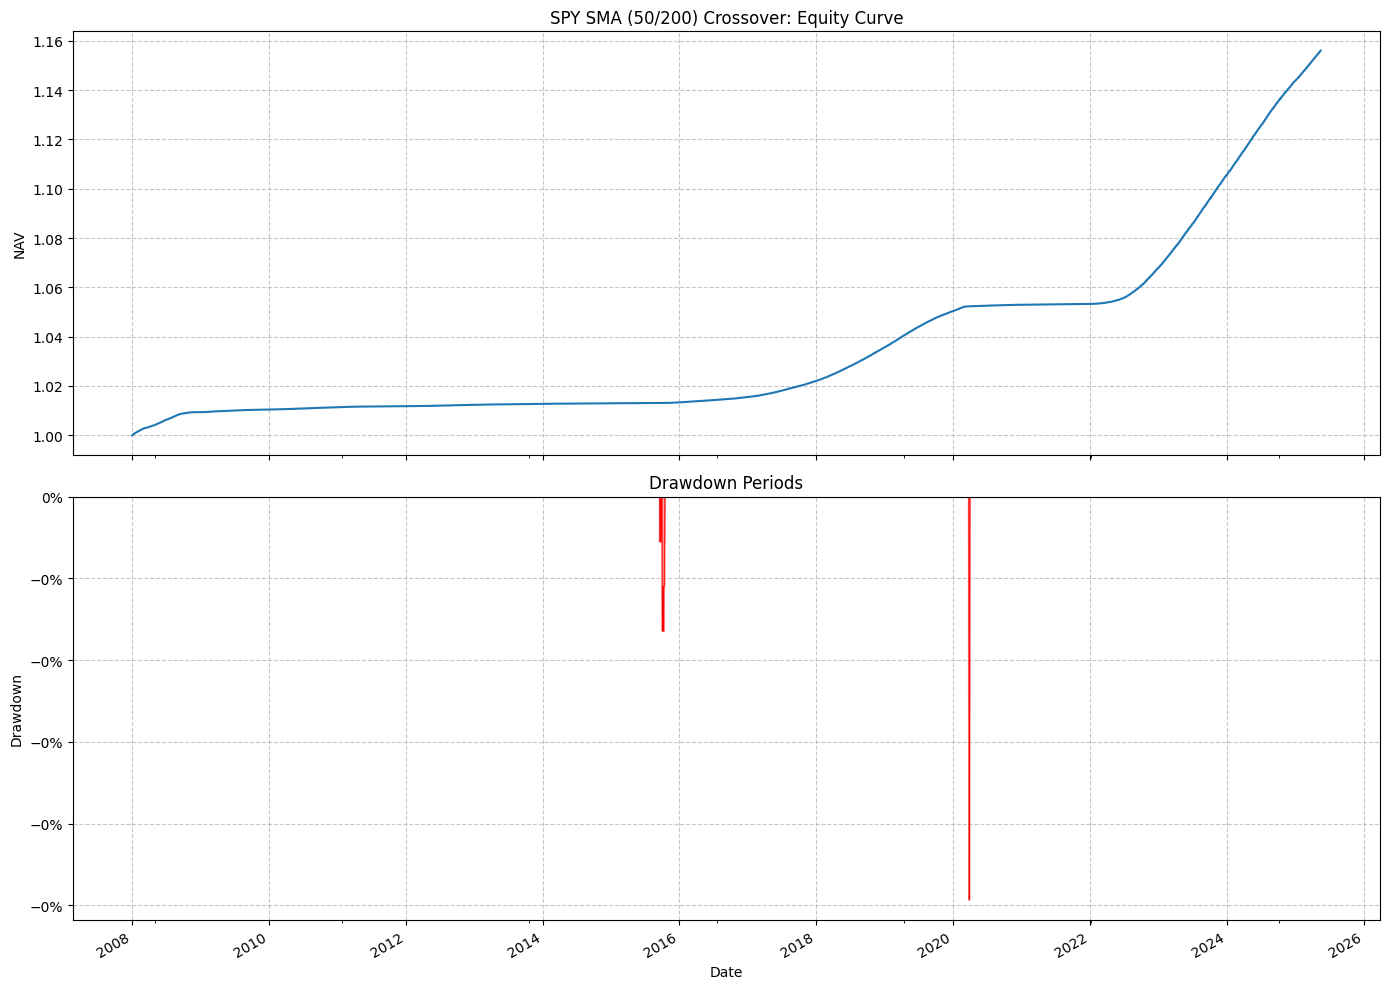

In [9]:
print("Plotting equity curve and drawdown periods...")
# Create a figure with two subplots (one for equity, one for drawdown)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True)

# Plot equity curve on the first subplot
metrics.plot_equity(result, ax=ax1)
ax1.set_title(f"SPY SMA ({short_window}/{long_window}) Crossover: Equity Curve")

# Plot drawdown periods on the second subplot
metrics.plot_drawdown(result, ax=ax2)
ax2.set_title("Drawdown Periods")

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

### Next Steps

- Try different signals or strategies (e.g., momentum, mean reversion, volatility-based models).
- Implement parameter sweeps to optimize strategy parameters (like SMA windows).
- Test the framework with other assets (e.g., QQQ, EFA, IEF) or a portfolio of assets.
- Enhance the `metrics` module with additional performance measures (e.g., Sortino ratio, Calmar ratio, rolling Sharpe ratio, beta, alpha).
- Develop more sophisticated transaction cost models (e.g., including slippage, fixed costs).
- Add support for short selling or different position sizing schemes.